In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import DLlib as dl
import pylib as py
import tf2lib as tl
import wflib as wf

import data
import mebcrn
from keras_unet.models import custom_unet

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tqdm
import h5py
import xlsxwriter
from skimage.metrics import structural_similarity
from itertools import cycle

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
experiment_dir = 'output/IDEAL-GAN-002'
n_echoes = 6
G_model = 'encod-decod'
te_input = False
n_filters = 32
batch_size = 1

In [3]:
############################################################
############### DIRECTORIES AND FILENAMES ##################
############################################################
dataset_dir = '../MATLAB/waterFatSignalPhantom/data_out/'
dataset_hdf5_1 = 'phantom.hdf5'

############################################################
################### LOAD DATASET 1 #########################
############################################################
if G_model == 'complex':
    ech_idx = n_echoes
else:
    ech_idx = n_echoes * 2
acqs_1, out_maps_1 = data.load_hdf5(dataset_dir,dataset_hdf5_1, ech_idx, complex_data=(G_model=='complex'))

print('Num. Elements- DS1:', len(acqs_1))

Num. Elements- DS1: 1


In [4]:
############################################################
################# DATASET PARTITIONS #######################
############################################################

testX   = acqs_1

testY   = out_maps_1

# Overall dataset statistics
len_dataset,hgt,wdt,d_ech = np.shape(testX)
_,_,_,n_out = np.shape(testY)
echoes = int(d_ech/2)
r2_sc,fm_sc = 200,300

print('Acquisition Dimensions:', hgt,wdt)
print('Echoes:',echoes)
print('Output Maps:',n_out)

# Input and output dimensions (testing data)
print('Testing input shape:',testX.shape)
print('Testing output shape:',testY.shape)

A_B_dataset_test = tf.data.Dataset.from_tensor_slices((testX,testY))
A_B_dataset_test.batch(batch_size)
test_iter = cycle(A_B_dataset_test)

Acquisition Dimensions: 192 192
Echoes: 6
Output Maps: 6
Testing input shape: (1, 192, 192, 12)
Testing output shape: (1, 192, 192, 6)


In [5]:
# model
if G_model == 'encod-decod':
    G_A2B = dl.PM_Generator(input_shape=(hgt,wdt,d_ech),
                            te_input=te_input,
                            te_shape=(n_echoes,),
                            filters=n_filters,
                            R2_self_attention=False,
                            FM_self_attention=True)
elif G_model == 'complex':
    G_A2B=dl.PM_complex(input_shape=(hgt,wdt,d_ech),
                        filters=n_filters,
                        te_input=te_input,
                        te_shape=(n_echoes,),
                        self_attention=False)
elif G_model == 'U-Net':
    G_A2B = custom_unet(input_shape=(hgt,wdt,d_ech),
                        num_classes=2,
                        use_attention=True,
                        filters=n_filters)
elif G_model == 'MEBCRN':
    G_A2B = mebcrn.MEBCRN(input_shape=(hgt,wdt,d_ech),
                          n_res_blocks=5,
                          n_downsamplings=2,
                          filters=24,
                          self_attention=True)

# restore
tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints')).restore()

In [6]:
# Reduced-Ideal model
@tf.function
def sample_A2B(A,TE=None,complex_data=False):
    indx_PM =tf.concat([tf.zeros_like(A[:,:,:,:1],dtype=tf.int32),
                        tf.ones_like(A[:,:,:,:1],dtype=tf.int32)],axis=-1)
    if te_input:
        A2B_PM = G_A2B([A,(TE-1e-3)/(11.5*1e-3)], training=False)
    else:
        A2B_PM = G_A2B(A, training=False)
    if G_model == 'U-Net':
        orig_shape = A2B_PM.shape
        A2B_R2, A2B_FM = tf.dynamic_partition(A2B_PM,indx_PM,num_partitions=2)
        A2B_R2 = tf.reshape(A2B_R2,A[:,:,:,:1].shape)
        A2B_FM = tf.reshape(A2B_FM,A[:,:,:,:1].shape)
        A2B_FM = (A2B_FM - 0.5) * 2
        A2B_PM = tf.concat([A2B_R2,A2B_FM],axis=-1)
    elif G_model == 'complex':
        A2B_R2 = tf.math.real(A2B_PM)
        A2B_FM = tf.math.imag(A2B_PM)
        A2B_PM = tf.concat([A2B_R2,A2B_FM],axis=-1)
    A2B_PM = tf.where(A[:,:,:,:2]!=0.0,A2B_PM,0)
    A2B_WF, A2B2A = wf.acq_to_acq(A,A2B_PM,TE,complex_data=complex_data)
    A2B = tf.concat([A2B_WF,A2B_PM],axis=-1)
    return A2B, A2B2A

@tf.function
def sample_B2A(B,TE=None,complex_data=False):
    indx_PM =tf.concat([tf.zeros_like(B[:,:,:,:1],dtype=tf.int32),
                        tf.ones_like(B[:,:,:,:1],dtype=tf.int32)],axis=-1)
    B2A = wf.IDEAL_model(B,TE)
    if te_input:
        B2A2B_PM = G_A2B([B2A,(TE-1e-3)/(11.5*1e-3)], training=False)
    else:
        B2A2B_PM = G_A2B(B2A, training=False)
    if G_model == 'U-Net':
        orig_shape = B2A2B_PM.shape
        B2A2B_R2, B2A2B_FM = tf.dynamic_partition(A2B_PM,indx_PM,num_partitions=2)
        B2A2B_R2 = tf.reshape(B2A2B_R2,B[:,:,:,:1].shape)
        B2A2B_FM = tf.reshape(B2A2B_FM,B[:,:,:,:1].shape)
        B2A2B_FM = (B2A2B_FM - 0.5) * 2
        B2A2B_PM = tf.concat([B2A2B_R2,B2A2B_FM],axis=-1)
        B2A2B_PM = tf.reshape(B2A2B_PM,orig_shape)
    elif G_model == 'complex':
        B2A2B_R2 = tf.math.real(B2A2B_PM)
        B2A2B_FM = tf.math.imag(B2A2B_PM)
        B2A2B_PM = tf.concat([B2A2B_R2,B2A2B_FM],axis=-1)
    B2A2B_WF = wf.get_rho(B2A,B2A2B_PM,TE,complex_data=complex_data)
    B2A2B = tf.concat([B2A2B_WF,B2A2B_PM],axis=-1)
    return B2A, B2A2B

In [7]:
# MDWF model
# @tf.function
# def sample_A2B(A):
#     B_mask = tf.concat([A,A],axis=-1)
#     A2B = G_A2B(A, training=False)
#     A2B = tf.where(B_mask[:,:,:,:6]!=0.0,A2B,0)
#     A2B2A = wf.IDEAL_model(A2B)
#     return A2B, A2B2A

# @tf.function
# def sample_B2A(B):
#     B2A = wf.IDEAL_model(B)
#     B2A2B = G_A2B(B2A, training=False)
#     B2A2B = tf.where(B!=0.0,A2B,0)
#     return B2A, B2A2B

In [8]:
def gen_TEvar(n_ech,bs,orig=False):
    stp_te = (12.5*n_ech/6)*1e-3
    if orig:
        TE_ini_var = 1.3 * 1e-3
        d_TE_var = 2.1 * 1e-3
    else:
        TE_ini_var = (1.2 + 0.2*np.random.uniform()) * 1e-3
        d_TE_var = (1.9 + 0.3*np.random.uniform()) * 1e-3
    te_var_np = np.arange(start=TE_ini_var,stop=stp_te,step=d_TE_var)
    te_var = tf.convert_to_tensor(te_var_np,dtype=tf.float32)
    te_var = tf.expand_dims(te_var,0)
    te_var = tf.tile(te_var,[bs,1])
    return te_var

In [9]:
A, B = next(test_iter)
A = tf.expand_dims(A,axis=0)
B = tf.expand_dims(B,axis=0)
if te_input:
    te_orig = gen_TEvar(n_echoes,batch_size,orig=True)
    A2B, A2B2A = sample_A2B(A, TE=te_orig, complex_data=(G_model=='complex'))
else:
    A2B, A2B2A = sample_A2B(A, complex_data=(G_model=='complex'))

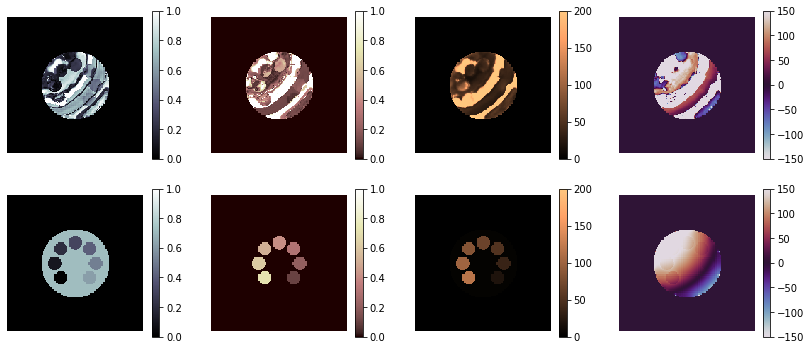

In [10]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8))=plt.subplots(figsize=(14, 6),
                                                        nrows=2, ncols=4)
# Ground truth in the first row
w_aux = np.squeeze(np.abs(tf.complex(A2B[:,:,:,0],A2B[:,:,:,1])))
W_ok = ax1.imshow(w_aux, cmap='bone',
                  interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=ax1)
ax1.axis('off')

f_aux = np.squeeze(np.abs(tf.complex(A2B[:,:,:,2],A2B[:,:,:,3])))
F_ok = ax2.imshow(f_aux, cmap='pink',
                  interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=ax2)
ax2.axis('off')

r2_aux = np.squeeze(A2B[:,:,:,4])
r2_ok = ax3.imshow(r2_aux*r2_sc, cmap='copper',
                   interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=ax3)
ax3.axis('off')

field_aux = np.squeeze(A2B[:,:,:,5]) 
field_ok = ax4.imshow(field_aux*fm_sc, cmap='twilight',
                      interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=ax4)
ax4.axis('off')

# Computed maps in the second row
wn_aux = np.squeeze(np.abs(tf.complex(B[:,:,:,0],B[:,:,:,1])))
W_unet = ax5.imshow(wn_aux, cmap='bone',
                    interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_unet, ax=ax5)
ax5.axis('off')

fn_aux = np.squeeze(np.abs(tf.complex(B[:,:,:,2],B[:,:,:,3])))
F_unet = ax6.imshow(fn_aux, cmap='pink',
                    interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_unet, ax=ax6)
ax6.axis('off')

r2n_aux = np.squeeze(B[:,:,:,4])
r2_unet = ax7.imshow(r2n_aux*r2_sc, cmap='copper',
                     interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_unet, ax=ax7)
ax7.axis('off')

fieldn_aux = np.squeeze(B[:,:,:,5])
field_unet = ax8.imshow(fieldn_aux*fm_sc, cmap='twilight',
                        interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_unet, ax=ax8)
ax8.axis('off')

plt.show()

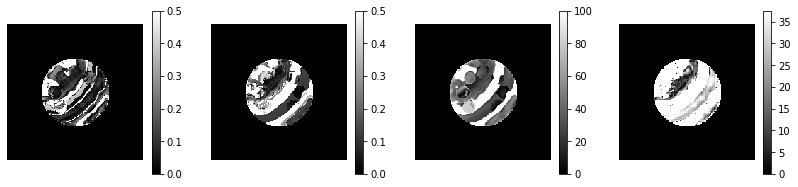

In [11]:
# DISPLAY ERROR (4 OUTPUTS)
fig_err, (ix1,ix2,ix3,ix4) = plt.subplots(figsize=(14, 3), nrows=1, ncols=4)

# Ground truth in the first row
w_err = np.abs(w_aux-wn_aux)
Wn_err = ix1.imshow(w_err, cmap='gray',
                    interpolation='none', vmin=0, vmax=0.5)
fig_err.colorbar(Wn_err, ax=ix1)
# ix1.set_title('Water Error')
ix1.axis('off')
f_err = np.abs(f_aux-fn_aux)
Fn_err = ix2.imshow(f_err, cmap='gray',
                    interpolation='none', vmin=0, vmax=0.5)
fig_err.colorbar(Fn_err, ax=ix2)
# ix2.set_title('Fat Error')
ix2.axis('off')
r2_err = np.abs(r2_aux-r2n_aux)*r2_sc
r2n_err = ix3.imshow(r2_err, cmap='gray',
                     interpolation='none', vmin=0, vmax=r2_sc/2)
fig_err.colorbar(r2n_err, ax=ix3)
# ix3.set_title('R2* Error')
ix3.axis('off')
field_err = np.abs(field_aux-fieldn_aux)*fm_sc
fieldn_err = ix4.imshow(field_err, cmap='gray',
                        interpolation='none', vmin=0, vmax=fm_sc/8)
fig_err.colorbar(fieldn_err, ax=ix4)
# ix4.set_title('Field Error')
ix4.axis('off')

plt.show()

In [12]:
MAE_w = np.mean(tf.abs(w_aux-wn_aux), axis=(0,1))
MAE_f = np.mean(tf.abs(f_aux-fn_aux), axis=(0,1))
MAE_r2 = np.mean(tf.abs(r2_aux-r2n_aux), axis=(0,1))
MAE_fm = np.mean(tf.abs(field_aux-fieldn_aux), axis=(0,1))
print('MAEs:',np.round([MAE_w,MAE_f,MAE_r2,MAE_fm],5))
print('R2* MAE [1/s]:',np.round(200*MAE_r2,5))
print('Field Map MAE [Hz]:',np.round(300*MAE_fm,5))

MAEs: [0.04611 0.13084 0.07522 0.0973 ]
R2* MAE [1/s]: 15.0433
Field Map MAE [Hz]: 29.18918


In [13]:
w_ssim = structural_similarity(w_aux,wn_aux,multichannel=False)
f_ssim = structural_similarity(f_aux,fn_aux,multichannel=False)
r2_ssim = structural_similarity(r2_aux,r2n_aux,multichannel=False)
fm_ssim = structural_similarity(field_aux,fieldn_aux,multichannel=False)
print('SSIMs:',np.round([w_ssim,f_ssim,r2_ssim,fm_ssim],5))

SSIMs: [0.85606 0.77626 0.79245 0.81751]


C:\Users\jpmen\AppData\Local\Temp\ipykernel_46744\912484574.py:1: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  w_ssim = structural_similarity(w_aux,wn_aux,multichannel=False)
C:\Users\jpmen\AppData\Local\Temp\ipykernel_46744\912484574.py:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  f_ssim = structural_similarity(f_aux,fn_aux,multichannel=False)
C:\Users\jpmen\AppData\Local\Temp\ipykernel_46744\912484574.py:3: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  r2_ssim = structural_similarity(r2_aux,r2n_aux,multichannel=False)
C:\Users\jpmen\AppData\Local\Temp\ipykernel_46744\912484574.py:4: FutureWarning: `multichannel` is a deprecated argument nam

C:\Users\jpmen\AppData\Local\Temp\ipykernel_46744\1245817175.py:2: RuntimeWarning: invalid value encountered in true_divide
  PDFF_res = f_aux/(w_aux+f_aux)
C:\Users\jpmen\AppData\Local\Temp\ipykernel_46744\1245817175.py:6: RuntimeWarning: invalid value encountered in true_divide
  PDFF_gt = fn_aux/(wn_aux+fn_aux)


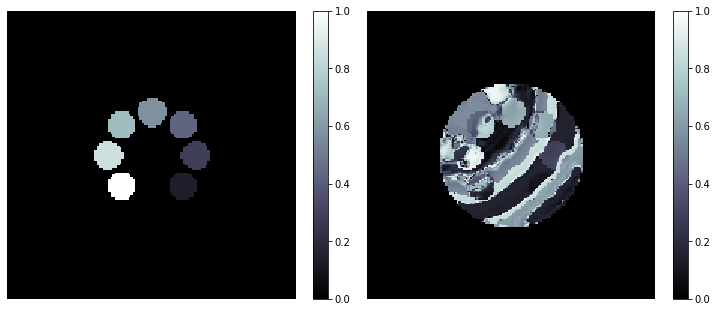

In [14]:
# Ground-Truth PDFF
PDFF_res = f_aux/(w_aux+f_aux)
PDFF_res[np.isnan(PDFF_res)] = 0.0

# Model Measured PDFF
PDFF_gt = fn_aux/(wn_aux+fn_aux)
PDFF_gt[np.isnan(PDFF_gt)] = 0.0

# Segmentation rectangle (ref. values for test data N°105)
verts_list = {1:   (69,109),#ok
              2:   (61,89),#ok
              3:   (69,68),#ok
              4:   (90,60),#ok
              5:  (110,68),#ok
              6:  (119,89),#ok
              7:  (110,109)}#ok

left_x,sup_y = verts_list[7]
rect_hgt,rect_wdt = 13,13
rect_gt = patches.Rectangle((left_x,sup_y),rect_wdt,rect_hgt,
                            linewidth=1,edgecolor='y',facecolor='none')
rect_res = patches.Rectangle((left_x,sup_y),rect_wdt,rect_hgt,
                             linewidth=1,edgecolor='r',facecolor='none')

fig_pdff, (ex1,ex2) = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

disp_pdff_ok = ex1.imshow(PDFF_gt, cmap='bone',
                          interpolation='none', vmin=0, vmax=1)
fig_pdff.colorbar(disp_pdff_ok, ax=ex1)
# ex1.set_title('PDFF Ground Truth',{'fontsize':15})
# ex1.add_patch(rect_gt)
ex1.axis('off')

disp_pdff_res = ex2.imshow(PDFF_res, cmap='bone',
                           interpolation='none', vmin=0, vmax=1)
fig_pdff.colorbar(disp_pdff_res, ax=ex2)
# ex2.set_title('Resulting PDFF',{'fontsize':15})
# ex2.add_patch(rect_res)
ex2.axis('off')

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0.1, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

In [15]:
r1,r2 = sup_y,(sup_y+rect_hgt)
c1,c2 = left_x,(left_x+rect_wdt)
PDFF_gt_crop = PDFF_gt[r1:r2,c1:c2]
PDFF_res_crop = PDFF_res[r1:r2,c1:c2]

print('Median of PDFF in the segmented region:')
print('Ground-Truth:\t',np.median(PDFF_gt_crop))
print('Model result:\t',np.median(PDFF_res_crop))

Median of PDFF in the segmented region:
Ground-Truth:	 0.14285715
Model result:	 0.60468733


In [16]:
PDFF_res_all = np.array([])
PDFF_gt_all = np.array([])
rect_hgt,rect_wdt = 13,13
for k in verts_list:
    left_x,sup_y = verts_list[k]
    r1,r2 = sup_y,(sup_y+rect_hgt)
    c1,c2 = left_x,(left_x+rect_wdt)
    # PDFF crops - magnitude model results
    # w_all = all_test_ans[(k_prev+4):(k-4),r1:r2,c1:c2,0]
    # f_all = all_test_ans[(k_prev+4):(k-4),r1:r2,c1:c2,1]
    # PDFF crops - complex model results
    w_all = np.abs(tf.complex(A2B[:,r1:r2,c1:c2,0],
                              A2B[:,r1:r2,c1:c2,1]))
    f_all = np.abs(tf.complex(A2B[:,r1:r2,c1:c2,2],
                              A2B[:,r1:r2,c1:c2,3]))
    PDFF_res_aux = np.median(f_all/(f_all+w_all),axis=(1,2))
    PDFF_res_all = np.concatenate((PDFF_res_all,PDFF_res_aux),axis=0)
    # PDFF crops - GT magnitude results
    # w_all_gt = testY[(k_prev+4):(k-4):,r1:r2,c1:c2,0]
    # f_all_gt = testY[(k_prev+4):(k-4),r1:r2,c1:c2,1]
    # PDFF crops - GT complex results
    w_all_gt = np.abs(tf.complex(B[:,r1:r2,c1:c2,0],
                                 B[:,r1:r2,c1:c2,1]))
    f_all_gt = np.abs(tf.complex(B[:,r1:r2,c1:c2,2],
                                 B[:,r1:r2,c1:c2,3]))
    PDFF_gt_aux = np.median(f_all_gt/(f_all_gt+w_all_gt),axis=(1,2))
    PDFF_gt_all = np.concatenate((PDFF_gt_all,PDFF_gt_aux),axis=0)

# Compute error
PDFF_err_list = PDFF_res_all-PDFF_gt_all
print('PDFF estimations:',np.round(PDFF_res_all,5))
print('Ground-truth:',np.round(PDFF_gt_all,5))
print('Errors:',np.round(PDFF_err_list,5))

# PDFF crops mean error
PDFF_err_mean = np.mean((PDFF_err_list))
PDFF_err_std = np.std((PDFF_err_list))
print('Mean PDFF error:',np.round(PDFF_err_mean*100,2),
      '+-',np.round(PDFF_err_std*100,2),'%')

PDFF estimations: [0.42825 0.7379  0.4617  0.64121 0.66173 0.30323 0.60469]
Ground-truth: [1.      0.85714 0.71429 0.57143 0.42857 0.28571 0.14286]
Errors: [-0.57175 -0.11925 -0.25259  0.06979  0.23316  0.01752  0.46183]
Mean PDFF error: -2.3 +- 31.03 %


In [17]:
r2_res_all = np.array([])
r2_gt_all = np.array([])
for k in verts_list:
    left_x,sup_y = verts_list[k]
    r1,r2 = sup_y,(sup_y+rect_hgt)
    c1,c2 = left_x,(left_x+rect_wdt)
    # R2* crops - complex model results
    r2_all = A2B[:,r1:r2,c1:c2,4]*r2_sc
    r2_res_aux = np.mean(r2_all,axis=(1,2))
    r2_res_all = np.concatenate((r2_res_all,r2_res_aux),axis=0)
    # R2* crops - GT complex results
    r2_all_gt = B[:,r1:r2,c1:c2,4]*r2_sc
    r2_gt_aux = np.mean(r2_all_gt,axis=(1,2))
    r2_gt_all = np.concatenate((r2_gt_all,r2_gt_aux),axis=0)

# Compute error
r2_err_list = r2_res_all-r2_gt_all
print('R2* estimations:',r2_res_all)
print('Ground-truth:',r2_gt_all)
print('Errors:\n',r2_err_list)

# R2* crops mean error
r2_err_mean = np.mean((r2_err_list))
r2_err_std = np.std((r2_err_list))
print('Mean R2* error:',np.round(r2_err_mean,2),
      '+-',np.round(r2_err_std,2),'[1/s]')

R2* estimations: [192.51940918  88.27753448  53.93959808  42.46281433 162.59570312
  61.96691132  93.50870514]
Ground-truth: [116.29426575 100.73673248  83.05337524  68.65546417  50.87547302
  35.8011322   19.47060394]
Errors:
 [ 76.22514343 -12.459198   -29.11377716 -26.19264984 111.7202301
  26.16577911  74.0381012 ]
Mean R2* error: 31.48 +- 52.38 [1/s]
